# SOCIAL PERFORMANCE INDEX

The main purpose of the social performance index (SPI) is to quantify how well the athletes are doing in their social media accounts. Are they engaging their audience? Does their audience have a positive perception about them? How big is their audience? this are questions that we are going to answer, aggregate and transform into a single, yet complex, index.

The social media platforms that we will be using are as follows:

* Instagram
* Facebook
* Twitter

For now we will be working with Instagram and Twitter. Facebook will be included in the near future.
We will be retrieving the following data:

* Instagram:
    * Number of followers
    * Number of following
    * Number of total posts
    * Number of likes
    * Comments of the posts
    * Number of comments
    

* Twitter:
    * Number of followers
    * Number of retweets
    * Number of tweets
    * Number of retweets to user
    * Number of favorites to user
    * Number of replies to user
    * Replies to user

Caveats:
* For Twitter, we will be having data only from the past 7 days. This is a restriction of the Twitter API.
* So far we will be extractring data that is publicly available. So, if the user account is private we will not be able to extract some of the features.
* Instagram restricts the number of comments we can retrieve from a profile. So we will be retrieving only the comments of the latest 10 posts.
    

### Importing libraries and tools

In [30]:
import requests
import mariadb
import math
import sys

import pandas       as pd
import numpy        as np
import datetime     as dt


from scipy              import stats
from pandas.api.types   import is_numeric_dtype
from pandas.api.types   import is_bool_dtype
from datetime           import datetime as dt
from datetime           import datetime, date
pd.set_option('display.max_columns', None)

# Connect to MariaDB Platform
try:
    conn = mariadb.connect(
        user="admin_vtx",
        password="Prueba12#",
        host="develop-free-vtx.csgmphwpjwca.us-east-1.rds.amazonaws.com",
        port=3306,
        database="catalogs"
    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

### Extracting athletes usernames

Now from our database we will retrieve the current athletes and their instagram and twitter usernames.

In [8]:
cur.execute("SELECT * FROM users;")

ids = []
names = []
instagram_usernames = []
twitter_usernames = []

for id, name, instagram_username, twitter_username, last_update, gender, date_of_birth, sport, position, email in cur: 
    ids.append(id)
    names.append(name)
    instagram_usernames.append(instagram_username)
    twitter_usernames.append(twitter_username)

df_athletes_social = pd.DataFrame({"id": ids, "name": names, "instagram_username": instagram_usernames, "twitter_username": twitter_usernames})
df_athletes_social


,id,name,instagram_username,twitter_username
0,001,Stephany Cruz,estefanycruz90,triplejumperGUA
1,002,Bernardo Uriel Barrondo,urielbarrondo,nan
2,002d1e57-41ac-44bb-a0b4-caa4adfc0726,Pepito perez,,
3,003,Maria Fernanda Peinado,marifer7104,nan
4,004,Danisha Chimillio,dashachimilio05,DarshyCastillo
5,005,Katya Oliveros,katya_oliveros27,nan
6,006,Maxwell Alvarez,maxwell.alvarez.98,nan
7,007,Guillermo Rivas,guillermoflores156,nan
8,008,Leonardo Oliveros,jeremx347,nan
9,009,Laura Lainfiesta,laura_lainfiesta,nan


Now that we have the usernames we will extract the data. We do this by an API that has been developed.
For those athletes that do not have an Instagram or Twitter account, the data will default to zero.

In [10]:
url_ig = "http://localhost:6000/api/instagram"
url_tw = "http://localhost:6000/api/twitter"

users_data = []

for ix, id in enumerate(ids):
    user_data_dict = {}
    user_data_dict["id"] = id
    user_data_dict["name"] = names[ix]
    user_data_dict["instagram_username"] = instagram_usernames[ix]
    user_data_dict["twitter_username"] = twitter_usernames[ix]
    print(f"Working on {names[ix]}")
    if user_data_dict["instagram_username"] is not None and user_data_dict["instagram_username"] != "nan" and user_data_dict["instagram_username"] != "":
        print("Getting IG data")
        body = {"username": user_data_dict["instagram_username"]}
        r = requests.post(url_ig, json=body)
        response = r.json()
        user_data_dict["instagram_data"] = response
    else:
        user_data_dict["instagram_data"] = {
                'username': '',
                "user_id_instagram": '',
                'n_followers': 0,
                'n_following': 0,
                'n_posts_total': 0,
                'n_posts_retrieved': 0,
                'n_likes_total': 0,
                'n_likes_retrieved': 0,
                'n_comments_total': 0,
                'n_comments_retrieved': 0,
                'created_at': datetime.now(),
                'sentiment_instagram': 0
            }

    if user_data_dict["twitter_username"] is not None and user_data_dict["twitter_username"] != "nan" and user_data_dict["twitter_username"] != "":
        print("Getting TW data")
        body = {"username": user_data_dict["twitter_username"]}
        r = requests.post(url_tw, json=body)
        response = r.json()
        user_data_dict["twitter_data"] = response
    else:
        user_data_dict["twitter_data"] = {
                'username': '',
                "n_followers": 0,
                'n_retweets': 0,
                'n_tweets': 0,
                'n_retweets_to_user': 0,
                'n_favorites_to_user': 0,
                'n_replies_to_user': 0,
                'created_at': datetime.now(),
                'sentiment_twitter': 0
            }
    
    users_data.append(user_data_dict)
    print(f"Done with {names[ix]}")
    print("----------------------------------")

Working on Stephany Cruz
Getting IG data
Getting TW data
Done with Stephany Cruz
----------------------------------
Working on Bernardo Uriel Barrondo
Getting IG data
Done with Bernardo Uriel Barrondo
----------------------------------
Working on Pepito perez
Done with Pepito perez
----------------------------------
Working on Maria Fernanda Peinado
Getting IG data
Done with Maria Fernanda Peinado
----------------------------------
Working on Danisha Chimillio
Getting IG data
Getting TW data
Done with Danisha Chimillio
----------------------------------
Working on Katya Oliveros
Getting IG data
Done with Katya Oliveros
----------------------------------
Working on Maxwell Alvarez
Getting IG data
Done with Maxwell Alvarez
----------------------------------
Working on Guillermo Rivas
Getting IG data
Done with Guillermo Rivas
----------------------------------
Working on Leonardo Oliveros
Getting IG data
Done with Leonardo Oliveros
----------------------------------
Working on Laura Lainf

Now that we have extracted the data, we are able to compute the Social Performance Index. Recall that the SPI tries to measure how well an athlete is doing in social media. The SPI of an athlete will be ranging between 0 and 100, and should consider both Instagram and Twitter. So we will compute a SPI for Twitter and another for Instagram, and then we will aggregate this two into the main SPI.

It is very important here to mention that we have also included a sentiment analysis component. This component computes an estimate of the audience perception towards the athlete based on the comments of the posts. An output close to 1, means that the comments of the posts are very positive; on the other hand, an output close to zero means that the comments of the posts are mostly negative.

We will also compute the engagement for each social media platform, based on the data we just extracted. For instance:

$IG_{engagement} = \frac{nLikes + nComments}{nFollowers}*100 $

$TW_{engagement} = \frac{nFavorites + nRetweetsToUser + nRepliesToUser}{nFollowers}*100 $

Notice that the engagement would range between 0 and 100.

Now, how are we going to go from the current data that we have to the SPI? Well, the SPI should be an aggregation of the features that we obtained. For example, it is clear that the higher the number of followers an athlete has the higher their SPI should be. 

Now let's get our hands dirty with the math.

The aggregation of the features suggests a weighted sum. The weigthed sum would allow us to give **more importance** to certain features. For example, the sentiment would be more important than the number of comments, therefore a *heavier* weight should be assigned to it, so we would have something like: 

$SPI_{IG} = w_{nFollowers}f_{nFollowers}(nFollowers) + ... w_{engagement}f_{engagement}(engagement)$, where, for any feature $s$, $w_s$ is a scalar and $f_s$ is a function

Now two questions arise:
1. What are the values for the weigths ($w_s$)?
2. What are the functions ($f_s$)?

The first question is trivial. These weights are determined by the business logic. As stated above, the sentiment is more important than the number of comments, and therefore, the asociated weigth with the sentiment should be higher than that of the number of comments. The sum of all the weights should be equal to one. This also tells us that if we want the SPI to range between 0 and 1, the maximum value of $f_s(s)$ is 100.

These are the weigths that we will use for Instagram:

|Feature | Weight |
|---|---|
|Number of followers |0.1|
|Number of total posts |0.1|
|Number of likes |0.2|
|Number of comments |0.1|
|Sentiment |0.3|
|Engagement | 0.2|

These are the weigths that we will use for Twitter:

|Feature | Weight |
|---|---|
|Number of followers |0.1|
|Number of retweets |0.05|
|Number of tweets |0.05|
|Number of retweets to user |0.1|
|Number of favorites to user |0.1|
|Number of replies to user |0.1|
|Sentiment |0.3|
|Engagement | 0.2|

The second question is not as trivial as the first one. We need to find a function $f_s$ for each feature $s$, outputs a value ranging from 0 to 100. Notice that for sentiment and engagement this is straightforward, as the values for these features are already ranging in between two fixed values, rescaling is all that is needed. However, for the other features it is more complex. At first one would think that this $f_s$ function could be simply an on-off function than given a threshold would return 0 if the value of the feature is below that threshold, or 100 if the value of the feature is equal or above the threshold. However, this approach neglects important data and we would have to setup the threshold. What threshold would be suitable? answering this question would require a much bigger dataset. 

How about considering the value of the feature based on the values of that same feature for the other athtletes? We could try normalizing or standardizing the features and then rescale to obtain values between 0 and 100. However, with this we are making the assumption that the distribution of the features is normal, and with the little data that we have we cannot make that assertion. We could not also tell if the distribution is a power-law distribution or poisson distribution, for the same reason.

Here is where percentiles come to mind. The percentiles tell what is the percentage of the population the value is above.

We will go with percentiles. In that case, the function $f_s$ will have the values of the other athletes for feature $s$ as an extra argument. So, this will be the functions for each feature:

Instagram 

|Feature | Function |
|---|---|
|Number of followers | Percentile |
|Number of total posts | Percentile |
|Number of likes | Percentile |
|Number of comments | Percentile |
|Sentiment | Scaled by 100 |
|Engagement | Scaled by 1|

Twitter

|Feature | Function |
|---|---|
|Number of followers |Percentile|
|Number of retweets |Percentile|
|Number of tweets |Percentile|
|Number of retweets to user |Percentile|
|Number of favorites to user |Percentile|
|Number of replies to user |Percentile|
|Sentiment | Scaled by 100 |
|Engagement | Scaled by 1 |


In [ ]:
def tuned_sigmoid_fair(x):
    return np.clip(1/(0.8+0.2*np.exp(-x/25+4)), a_min=0, a_max=1)*100
def exponential(x):
    return np.clip(np.exp(x/25)/np.exp(4), a_min=0, a_max=1)*100

def compute_spi_ig(x):
    if x["username"] == "":
        return 0
    else:
        spi_ig_weights_dict = {
            "n_followers": 0.1,
            "n_posts_total": 0.1, 
            "n_likes_retrieved": 0.2, 
            "n_comments_retrieved": 0.1, 
            "sentiment_instagram": 0.3, 
            "relative_engagement": 0.2
        }
        spi = 0
        for k in spi_ig_weights_dict.keys():
            spi += spi_ig_weights_dict[k]*x[k]
        return tuned_sigmoid_fair(spi)

def process_ig_data(data):
    users_data_instagram = []
    for user_data in data:
        if ("instagram_data" in user_data.keys()):
            dict_data = user_data["instagram_data"].copy()
            dict_data["user_id"] = user_data["id"]
            users_data_instagram.append(dict_data)
        else:
            empty_dict = {'user_id': users_data["id"],
                        'username': '',
                        "user_id_instagram": '',
                        'n_followers': 0,
                        'n_following': 0,
                        'n_posts_total': 0,
                        'n_posts_retrieved': 0,
                        'n_likes_total': 0,
                        'n_likes_retrieved': 0,
                        'n_comments_total': 0,
                        'n_comments_retrieved': 0,
                        'created_at': '',
                        'sentiment_instagram': 0}
            users_data_instagram.append(empty_dict)
        
    df_ig = pd.DataFrame(users_data_instagram)
    df_ig["relative_engagement"] = df_ig.apply(lambda x: 0 if x["n_followers"] == 0 else np.clip((x["n_likes_retrieved"] + x["n_comments_retrieved"])/(x["n_followers"])*100, 0, 100), axis=1)
    df_ig["sentiment_instagram"] = df_ig["sentiment_instagram"]*100
    selected_cols_perc = ["username","n_followers", "n_posts_total", "n_likes_retrieved", "n_comments_retrieved"]
    selected_cols = ["username", "n_followers", "n_posts_total", "n_likes_retrieved", "n_comments_retrieved", "sentiment_instagram", "relative_engagement"]

    df_ig_perc = df_ig.copy()
    for col in selected_cols_perc:
        if col == "username":
            pass
        else:
            df_ig_perc[col] = df_ig_perc[col].apply(lambda x: stats.percentileofscore(df_ig_perc[df_ig_perc["username"] != ""][col], x))
    df_ig_perc["spi"] = df_ig_perc[selected_cols].apply(compute_spi_ig, axis=1)
    spi_ig_columns = ["user_id", "username", "n_followers", "n_posts_total", "n_likes_retrieved", "n_comments_retrieved", "sentiment_instagram", "relative_engagement"]
    return pd.concat([df_ig[spi_ig_columns], df_ig_perc["spi"], df_ig["created_at"]], axis=1)

def compute_spi_tw(x):
    if x["username"] == "":
        return 0
    else:
        spi_ig_weights_dict = {
            "n_followers": 0.1,
            "n_retweets": 0.1, 
            "n_tweets": 0.1, 
            "n_retweets_to_user": 0.1, 
            "n_favorites_to_user": 0.1, 
            "n_replies_to_user": 0.1,
            "sentiment_twitter": 0.3,
            "relative_engagement": 0.1
        }
        spi = 0
        for k in spi_ig_weights_dict.keys():
            spi += spi_ig_weights_dict[k]*x[k]
        return tuned_sigmoid_fair(spi)

def process_tw_data(data):
    users_data_twitter = []
    for user_data in data:
        if ("twitter_data" in user_data.keys()):
            dict_data = user_data["twitter_data"].copy()
            dict_data["user_id"] = user_data["id"]
            users_data_twitter.append(dict_data)
        else:
            empty_dict = {'user_id': user_data["id"],
                        'username': '',
                        "n_followers": 0,
                        'n_retweets': 0,
                        'n_tweets': 0,
                        'n_retweets_to_user': 0,
                        'n_favorites_to_user': 0,
                        'n_replies_to_user': 0,
                        'created_at': dt.now(),
                        'sentiment_twitter': 0}
            users_data_twitter.append(empty_dict)
    
    df_tw = pd.DataFrame(users_data_twitter)
    df_tw["relative_engagement"] = (df_tw.apply(lambda x: (x["n_favorites_to_user"] + x["n_retweets_to_user"] + x["n_replies_to_user"])/(x["n_followers"])*100 if x["n_tweets"] > 0 else 0, axis=1))
    df_tw["sentiment_twitter"] = df_tw["sentiment_twitter"]*100
    selected_cols_perc = ["username", "n_followers", "n_retweets", "n_tweets", "n_retweets_to_user", "n_favorites_to_user", "n_replies_to_user"]
    selected_cols = ["username", "n_followers", "n_retweets", "n_tweets", "n_retweets_to_user", "n_favorites_to_user", "n_replies_to_user", "sentiment_twitter", "relative_engagement"]
    
    df_tw_perc = df_tw.copy()
    for col in selected_cols_perc:
        if col == "username":
            pass
        else:
            df_tw_perc[col] = df_tw_perc[col].apply(lambda x: stats.percentileofscore(df_tw_perc[df_tw_perc["username"] != ""][col], x))
    df_tw_perc["spi"] = df_tw_perc[selected_cols].apply(compute_spi_tw, axis=1)
    spi_tw_columns = ["user_id","username","n_followers","n_retweets","n_tweets","n_retweets_to_user","n_favorites_to_user","n_replies_to_user","sentiment_twitter","relative_engagement"]
    return pd.concat([df_tw[spi_tw_columns], df_tw_perc["spi"], df_tw["created_at"]], axis=1)

processed_ig_data = process_ig_data(users_data)
processed_tw_data = process_tw_data(users_data)

The formulas for the SPIs would be:

$IG_{SPI}(x) = 0.1Perc(x_{nFollowers},X_{nFollowers}) + 0.1Perc(x_{nTotaPosts},X_{nTotaPosts}) + 0.2Perc(x_{nLikes},X_{nLikes}) + 0.1Perc(x_{nComments},X_{nComments}) + 0.3*(100*Sentiment) + 0.2*Engagement$

$TW_{SPI}(x) = 0.1Perc(x_{nFollowers},X_{nFollowers}) + 0.05Perc(x_{nRetweets},X_{nRetweets}) + 0.05Perc(x_{nTweets},X_{nTweets}) + 0.1Perc(x_{nRetweetsUser},X_{nRetweetsUser}) + 0.1Perc(x_{nFavorites},X_{nFavorites}) + 0.1Perc(x_{nRepliesUser},X_{nRepliesUser}) + 0.3*(100*Sentiment) + 0.2*Engagement$

Now let us add a particular behavior for the SPI. We will add a function that will encourage the athlete to get a higher SPI by boosting the increases in higher values of SPI

$IG_{SPI_{mod}}(x) = 100*\frac{1}{0.8+0.2e^{-\frac{IG_{SPI}(x)}{24}+4}}$ 

$TW_{SPI_{mod}}(x) = 100*\frac{1}{0.8+0.2e^{-\frac{TW_{SPI}(x)}{24}+4}}$ 

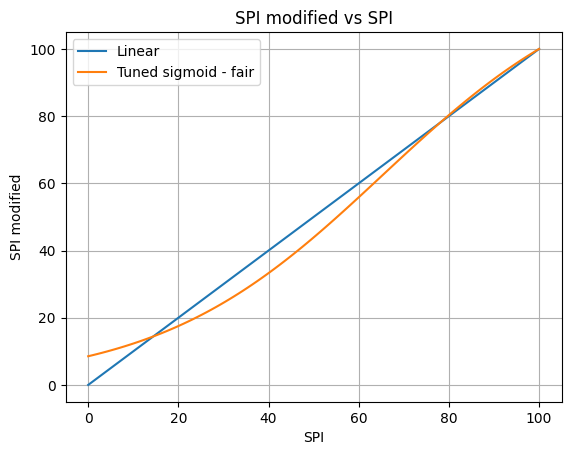

In [28]:
import matplotlib.pyplot as plt

x = np.linspace(0,100,100)
y_4 = 1/(0.8+0.2*np.exp(-x/25+4))
plt.plot(x,x, label="Linear")
plt.plot(x,100*y_4, label="Tuned sigmoid - fair")
plt.grid()
plt.legend()
plt.xlabel("SPI")
plt.ylabel("SPI modified")
plt.title("SPI modified vs SPI");

In [14]:
processed_ig_data

,user_id,username,n_followers,n_posts_total,n_likes_retrieved,n_comments_retrieved,sentiment_instagram,relative_engagement,spi,created_at
0,001,estefanycruz90,8424,493,2713,38,75.543658,32.656695,73.915953,2022-12-29 09:48:22.726903
1,002,urielbarrondo,1853,30,2546,80,77.983876,100.000000,81.555321,2022-12-29 09:48:51.244283
2,002d1e57-41ac-44bb-a0b4-caa4adfc0726,,0,0,0,0,0.000000,0.000000,0.000000,2022-12-29 09:49:03.288914
3,003,marifer7104,512,12,1015,89,89.512793,100.000000,72.006946,2022-12-29 09:49:23.651826
4,004,dashachimilio05,1177,16,2137,87,84.132298,100.000000,76.550256,2022-12-29 09:49:53.256257
5,005,katya_oliveros27,1851,14,0,0,20.000000,0.000000,19.360744,2022-12-29 09:50:11.667056
6,006,maxwell.alvarez.98,799,3,375,12,66.395629,48.435544,42.585629,2022-12-29 09:50:22.041550
7,007,guillermoflores156,334,10,0,0,20.000000,0.000000,15.248928,2022-12-29 09:50:29.442311
8,008,jeremx347,901,1,0,0,20.000000,0.000000,16.092197,2022-12-29 09:50:35.983307
9,009,laura_lainfiesta,4887,58,5390,188,81.421777,100.000000,92.362974,2022-12-29 09:51:02.976727


In [17]:
processed_tw_data

,user_id,username,n_followers,n_retweets,n_tweets,n_retweets_to_user,n_favorites_to_user,n_replies_to_user,sentiment_twitter,relative_engagement,spi,created_at
0,001,triplejumperGUA,749,0,0,0,0,0,20.0,0,43.145298,2022-12-29 09:48:30.390990
1,002,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:49:03.288914
2,002d1e57-41ac-44bb-a0b4-caa4adfc0726,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:49:03.288914
3,003,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:49:33.595739
4,004,DarshyCastillo,0,0,0,0,0,0,20.0,0,35.950767,2022-12-29 09:50:05.105363
5,005,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:13.719326
6,006,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:24.922249
7,007,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:31.479929
8,008,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:38.026788
9,009,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:51:22.168031


Now we will consider adding a bonus based on the improvements since the previous evaluation of the SPI. It will consider the relative change based on the previous values.

$SPI_{bonus}(x) = \sum_{i=1}^{k}w_i\frac{(x_i^{(curr)} - x_i^{(prev)})}{x_i^{(prev)}}$

The bonus will also range between 0 and 100. We will add an exponential behoaviour to the bonus favouring the highest values of $SPI_{bonus}$

Thus, the final SPI would be:

$SPI_{def}(x) = SPI(x) + 0.15\frac{e^{\frac{SPI_{bonus}(x)}{25}}}{e^4}$


In [31]:
def input_ig_data(cur, record):
    record_dict = record.to_dict('records')[0]
    cur.execute("INSERT INTO instagram_stats(user_id, instagram_username, n_followers, n_posts_total, n_likes_retrieved, n_comments_retrieved, sentiment, engagement, spi, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, now());",
      (record_dict["user_id"], record_dict["username"], record_dict["n_followers"], record_dict["n_posts_total"], record_dict["n_likes_retrieved"], record_dict["n_comments_retrieved"], record_dict["sentiment_instagram"], record_dict["relative_engagement"], record_dict["spi"]))

def retrieve_latest_record_ig(user_id):
    cur.execute(f"SELECT * FROM instagram_stats WHERE user_id = '{user_id}' ORDER BY created_at DESC LIMIT 1;") 
    for record_id, user_id, instagram_username, n_followers, n_posts_total, n_likes_retrieved, n_comments_retrieved, sentiment, engagement, spi, created_at in cur:
        record_dict = {
            "user_id": user_id,
            "username": instagram_username,
            "n_followers": n_followers,
            "n_posts_total": n_posts_total,
            "n_likes_retrieved": n_likes_retrieved,
            "n_comments_retrieved": n_comments_retrieved,
            "sentiment_instagram": sentiment,
            "relative_engagement": engagement,
            "spi": spi,
            "created_at": created_at
        }
    return pd.DataFrame(record_dict, index=[0])

def compute_definitive_ig_spi(user_id, new_record, bonus_weight=0.15):
    cur.execute(f"SELECT COUNT(*) FROM instagram_stats WHERE user_id = '{user_id}';") 
    for result in cur: 
        count_records = result[0]
    if count_records == 0:
        return new_record
    else: 
        
        dict_change = {}
        num_cols = [col for col in new_record.columns if is_numeric_dtype(new_record[col])]
        dict_change["username"] = new_record["username"].unique()[0]

        latest_record_db = retrieve_latest_record_ig(user_id)
        
        for col in num_cols:
            dict_change[col] = new_record.loc[0][col] - latest_record_db.loc[0][col]
            
        df_change = pd.DataFrame(dict_change, index=[0])
        
        dict_relative_change = {}
        dict_change = df_change.to_dict('records')[0]
        dict_base = latest_record_db.loc[0].to_dict()

        for key in dict_change.keys():
            if key == "username":
                dict_relative_change[key] = dict_change[key]
            elif key == "created_at" or key == "spi":
                pass
            else:
                if dict_base[key] == 0 and dict_change[key] != 0:
                    dict_relative_change[key] = 1
                elif dict_base[key] == 0 and dict_change[key] == 0:
                    dict_relative_change[key] = 0
                else:
                    dict_relative_change[key] = np.clip(dict_change[key] / dict_base[key], a_min=0, a_max=1)
                    
        dict_ig_spi_bonus_weight = {
            'n_followers': 0.1,
            'n_posts_total': 0.1,
            'n_likes_retrieved': 0.2,
            'n_comments_retrieved': 0.1,
            'sentiment_instagram': 0.3,
            'relative_engagement': 0.2
        }
        bonus_spi = 0
        for k in dict_relative_change.keys():
            if k != "username" and k != "user_id":
                bonus_spi += max(0, dict_ig_spi_bonus_weight[k]*dict_relative_change[k])

        new_record_upd = new_record.copy()
        if bonus_spi == 0:
            new_record_upd.loc[0, "spi"] = np.clip(new_record_upd.loc[0, "spi"], a_min=0, a_max=100)  
        else:     
            new_record_upd.loc[0, "spi"] = np.clip(new_record_upd.loc[0, "spi"] + bonus_weight*exponential(bonus_spi*100), a_min=0, a_max=100) 
        return new_record_upd[:1]
    
df_updated_ig = pd.DataFrame()
for user_id in processed_ig_data["user_id"].unique():
    new_record = processed_ig_data[processed_ig_data["user_id"] == user_id].reset_index().drop("index", axis=1)
    df_updated_ig = pd.concat([df_updated_ig, compute_definitive_ig_spi(user_id, new_record)], axis=0, ignore_index=True)

df_ig_fully_proc = pd.DataFrame()
for user_id in processed_ig_data["user_id"].unique():
    new_record = processed_ig_data[processed_ig_data["user_id"] == user_id].reset_index().drop("index", axis=1)
    record_updated = compute_definitive_ig_spi(user_id, new_record)
    df_ig_fully_proc = pd.concat([df_ig_fully_proc, record_updated], axis=0, ignore_index=True)
    input_ig_data(cur, record_updated)

def input_tw_data(cur, record):
    record_dict = record.to_dict('records')[0]
    cur.execute("INSERT INTO twitter_stats(user_id, twitter_username, n_followers, n_retweets , n_tweets , n_retweets_to_user , n_favorites_to_user, n_replies_to_user, sentiment, engagement, spi, created_at) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, now());",
      (record_dict["user_id"], record_dict["username"], record_dict["n_followers"], record_dict["n_retweets"], record_dict["n_tweets"], record_dict["n_retweets_to_user"], record_dict["n_favorites_to_user"], record_dict["n_replies_to_user"], record_dict["sentiment_twitter"], record_dict["relative_engagement"], record_dict["spi"]))

def retrieve_latest_record_tw(user_id):
    cur.execute(f"SELECT * FROM twitter_stats WHERE user_id = '{user_id}' ORDER BY created_at DESC LIMIT 1;") 
    for record_id, user_id, twitter_username, n_followers, n_retweets, n_tweets, n_retweets_to_user, n_favorites_to_user, n_replies_to_user, sentiment, engagement, spi, created_at in cur:
        record_dict = {
            "user_id": user_id,
            "username": twitter_username,
            "n_followers": n_followers,
            "n_retweets": n_retweets,
            "n_tweets": n_tweets,
            "n_retweets_to_user": n_retweets_to_user,
            "n_favorites_to_user": n_favorites_to_user,
            "n_replies_to_user": n_replies_to_user,
            "sentiment_twitter": sentiment,
            "relative_engagement": engagement,
            "spi": spi,
            "created_at": created_at
        }
    return pd.DataFrame(record_dict, index=[0])
      

def compute_definitive_tw_spi(user_id, new_record, bonus_weight=0.15):
    cur.execute(f"SELECT COUNT(*) FROM twitter_stats WHERE user_id = '{user_id}';") 
    for result in cur: 
        count_records = result[0]
    if count_records == 0:
        return new_record
    else: 
        
        dict_change = {}
        num_cols = [col for col in new_record.columns if is_numeric_dtype(new_record[col])]
        dict_change["username"] = new_record["username"].unique()[0]

        latest_record_db = retrieve_latest_record_tw(user_id)
        for col in num_cols:
            dict_change[col] = new_record.loc[0][col] - latest_record_db.loc[0][col]
            
        df_change = pd.DataFrame(dict_change, index=[0])
        
        dict_relative_change = {}
        dict_change = df_change.to_dict('records')[0]
        dict_base = latest_record_db.loc[0].to_dict()

        for key in dict_change.keys():
            if key == "username":
                dict_relative_change[key] = dict_change[key]
            elif key == "created_at" or key == "spi":
                pass
            else:
                if dict_base[key] == 0 and dict_change[key] != 0:
                    dict_relative_change[key] = 1
                elif dict_base[key] == 0 and dict_change[key] == 0:
                    dict_relative_change[key] = 0
                else:
                    dict_relative_change[key] = np.clip(dict_change[key] / dict_base[key], a_min=0, a_max=0)
                    
        dict_tw_spi_bonus_weight = {
        'n_followers': 0.1,
        'n_retweets': 0.1,
        'n_tweets': 0.1,
        'n_retweets_to_user': 0.1,
        'n_favorites_to_user': 0.1,
        'n_replies_to_user': 0.1,
        'sentiment_twitter': 0.3,
        'relative_engagement': 0.1
    }

        bonus_spi = 0
        for k in dict_relative_change.keys():
            if k != "username" and k != "user_id":
                bonus_spi += max(0, dict_tw_spi_bonus_weight[k]*dict_relative_change[k])

        new_record_upd = new_record.copy()
        if bonus_spi == 0:
            new_record_upd.loc[0, "spi"] = np.clip(new_record_upd.loc[0, "spi"], a_min=0, a_max=100) 
        else:
            new_record_upd.loc[0, "spi"] = np.clip(new_record_upd.loc[0, "spi"] + bonus_weight*exponential(bonus_spi*100), a_min=0, a_max=100) 
            

        return new_record_upd[:1]

df_tw_fully_proc = pd.DataFrame()
for user_id in processed_tw_data["user_id"].unique():
    new_record = processed_tw_data[processed_tw_data["user_id"] == user_id].reset_index().drop("index", axis=1)
    record_updated = compute_definitive_tw_spi(user_id, new_record)
    df_tw_fully_proc = pd.concat([df_tw_fully_proc, record_updated], axis=0, ignore_index=True)
    input_tw_data(cur, record_updated)

In [33]:
df_ig_fully_proc

,user_id,username,n_followers,n_posts_total,n_likes_retrieved,n_comments_retrieved,sentiment_instagram,relative_engagement,spi,created_at
0,001,estefanycruz90,8424,493,2713,38,75.543658,32.656695,74.828104,2022-12-29 09:48:22.726903
1,002,urielbarrondo,1853,30,2546,80,77.983876,100.000000,82.467472,2022-12-29 09:48:51.244283
2,002d1e57-41ac-44bb-a0b4-caa4adfc0726,,0,0,0,0,0.000000,0.000000,0.000000,2022-12-29 09:49:03.288914
3,003,marifer7104,512,12,1015,89,89.512793,100.000000,72.919097,2022-12-29 09:49:23.651826
4,004,dashachimilio05,1177,16,2137,87,84.132298,100.000000,77.462717,2022-12-29 09:49:53.256257
5,005,katya_oliveros27,1851,14,0,0,20.000000,0.000000,20.272894,2022-12-29 09:50:11.667056
6,006,maxwell.alvarez.98,799,3,375,12,66.395629,48.435544,43.497781,2022-12-29 09:50:22.041550
7,007,guillermoflores156,334,10,0,0,20.000000,0.000000,16.161079,2022-12-29 09:50:29.442311
8,008,jeremx347,901,1,0,0,20.000000,0.000000,17.004348,2022-12-29 09:50:35.983307
9,009,laura_lainfiesta,4887,58,5390,188,81.421777,100.000000,93.275125,2022-12-29 09:51:02.976727


In [34]:
df_tw_fully_proc

,user_id,username,n_followers,n_retweets,n_tweets,n_retweets_to_user,n_favorites_to_user,n_replies_to_user,sentiment_twitter,relative_engagement,spi,created_at
0,001,triplejumperGUA,749,0,0,0,0,0,20.0,0,43.145298,2022-12-29 09:48:30.390990
1,002,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:49:03.288914
2,002d1e57-41ac-44bb-a0b4-caa4adfc0726,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:49:03.288914
3,003,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:49:33.595739
4,004,DarshyCastillo,0,0,0,0,0,0,20.0,0,35.950767,2022-12-29 09:50:05.105363
5,005,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:13.719326
6,006,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:24.922249
7,007,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:31.479929
8,008,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:50:38.026788
9,009,,0,0,0,0,0,0,0.0,0,0.000000,2022-12-29 09:51:22.168031


Now that we have computed the SPIS for Instagram and Twitter it is time to aggregate them in order to compute a unique SPI for athlete. We will do so based on the proportion of use the athlete gives to either social media platform. If they use more Instagram than Twitter we will give a greater importance to Instagram.

To quantify the use we will consider the number of posts for Instagram and the Number of tweets for twitter. We will compute a weighted sum based on these.

$SPI(x) = \frac{nPosts*SPI_{IG} + nTweets*SPI_{TW}}{nPosts+nTweets}$

In [37]:
def agg_spi(x):
    if x["n_posts_total"] == 0 and x["n_tweets"] == 0:
        return (x["spi_instagram"] + x["spi_twitter"])/2
    else:
        return (x["n_posts_total"]*x["spi_instagram"] + x["n_tweets"]*x["spi_twitter"])/(x["n_posts_total"]+x["n_tweets"])

spi_df = pd.merge(df_ig_fully_proc[["user_id", "spi", "n_posts_total"]], df_tw_fully_proc[["user_id", "spi", "n_tweets"]], on="user_id", suffixes=["_instagram", "_twitter"])
spi_df["agg_spi"] = spi_df.apply(agg_spi, axis=1)
spi_df

,user_id,spi_instagram,n_posts_total,spi_twitter,n_tweets,agg_spi
0,001,74.828104,493,43.145298,0,74.828104
1,002,82.467472,30,0.000000,0,82.467472
2,002d1e57-41ac-44bb-a0b4-caa4adfc0726,0.000000,0,0.000000,0,0.000000
3,003,72.919097,12,0.000000,0,72.919097
4,004,77.462717,16,35.950767,0,77.462717
5,005,20.272894,14,0.000000,0,20.272894
6,006,43.497781,3,0.000000,0,43.497781
7,007,16.161079,10,0.000000,0,16.161079
8,008,17.004348,1,0.000000,0,17.004348
9,009,93.275125,58,0.000000,0,93.275125


In [ ]:
def input_spi_data(cur, record):
        record_dict = record.to_dict('records')[0]
        cur.execute("INSERT INTO spis(user_id, spi, spi_instagram, spi_twitter, created_at) VALUES (?, ?, ?, ?, now());",
        (record_dict["user_id"], record_dict["spi"], record_dict["spi_instagram"], record_dict["spi_twitter"]))

def agg_spi(x):
    if x["n_posts_total"] == 0 and x["n_tweets"] == 0:
        return (x["spi_instagram"] + x["spi_twitter"])/2
    else:
        return (x["n_posts_total"]*x["spi_instagram"] + x["n_tweets"]*x["spi_twitter"])/(x["n_posts_total"]+x["n_tweets"])

spi_df = pd.merge(df_ig_fully_proc[["user_id", "spi", "n_posts_total"]], df_tw_fully_proc[["user_id", "spi", "n_tweets"]], on="user_id", suffixes=["_instagram", "_twitter"])
spi_df["spi"] = spi_df.apply(agg_spi, axis=1)

for user_id in spi_df["user_id"].unique():
    new_record = spi_df[spi_df["user_id"] == user_id].reset_index().drop("index", axis=1)
    input_spi_data(cur, new_record) 